In [1]:
# 1. Install Dependencies
!pip install -q torch torchvision transformers accelerate kornia

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from PIL import Image
import numpy as np
import os
import zipfile

# 2. Setup & Unzip Data
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Unzip the dataset (Change path if needed)
zip_path = '/content/drive/MyDrive/DAv2-Finetuning/processed_dataset.zip'
extract_path = '/content/dataset'

if not os.path.exists(extract_path):
    print("Unzipping dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Done!")

# 3. Define the Dataset Class (Specific for .npy depth)
class CustomDepthDataset(Dataset):
    def __init__(self, root_dir, processor):
        self.root_dir = root_dir
        self.images_dir = os.path.join(root_dir, "images")
        self.depths_dir = os.path.join(root_dir, "depths")

        # Get list of IDs based on files present
        self.filenames = [f for f in os.listdir(self.images_dir) if f.endswith('.jpg')]
        self.processor = processor

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Get file names
        img_name = self.filenames[idx]
        id_base = os.path.splitext(img_name)[0]
        depth_name = id_base + ".npy"

        # Load Image
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        # Load Depth (Numpy)
        depth_path = os.path.join(self.depths_dir, depth_name)
        depth = np.load(depth_path).astype(np.float32)

        # Prepare for Model
        # Depth Anything expects specific input sizes.
        # We let the processor handle the image resizing/normalization.
        inputs = self.processor(images=image, return_tensors="pt")

        # We must resize the Ground Truth depth to match the model's output size (or vice versa)
        # It is usually easier to resize GT to the input size the model expects (e.g. 518x518)
        target_size = inputs["pixel_values"].shape[-2:] # (H, W)

        # Resize Depth Map
        depth_tensor = torch.from_numpy(depth).unsqueeze(0).unsqueeze(0) # (1, 1, H, W)
        depth_resized = torch.nn.functional.interpolate(
            depth_tensor, size=target_size, mode='nearest'
        ).squeeze()

        return {
            "pixel_values": inputs["pixel_values"].squeeze(0),
            "labels": depth_resized
        }

# 4. Load Model & Prepare
MODEL_ID = "depth-anything/Depth-Anything-V2-Small-hf"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = AutoImageProcessor.from_pretrained(MODEL_ID)
model = AutoModelForDepthEstimation.from_pretrained(MODEL_ID).to(device)

# Freezing Strategy (Same as before)
backbone = model.depth_anything.encoder if hasattr(model, "depth_anything") else model.backbone
for param in backbone.parameters():
    param.requires_grad = False

# 5. Initialize Dataset
dataset = CustomDepthDataset(extract_path, processor)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# 6. Training Loop
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)
NUM_EPOCHS = 5

model.train()
print(f"Starting training on {len(dataset)} images...")

for epoch in range(NUM_EPOCHS):
    total_loss = 0
    for batch in dataloader:
        # Move to GPU
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        # Forward Pass
        outputs = model(pixel_values=pixel_values)
        predicted_depth = outputs.predicted_depth

        # Upsample prediction to match label size (if model output is smaller)
        prediction = torch.nn.functional.interpolate(
            predicted_depth.unsqueeze(1),
            size=labels.shape[-2:],
            mode="bicubic",
            align_corners=False
        ).squeeze(1)

        # Loss Calculation (Supervised L1 Loss)
        # We mask out invalid values (if depth=0 or inf in your dataset)
        valid_mask = (labels > 0)
        if valid_mask.sum() > 0:
            loss = torch.nn.functional.l1_loss(prediction[valid_mask], labels[valid_mask])
        else:
            loss = torch.tensor(0.0, requires_grad=True).to(device)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Avg Loss = {total_loss / len(dataloader):.4f}")

# Save Model
model.save_pretrained("fine_tuned_depth_model")
print("Model saved successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 77.7 MB/s eta 0:00:00
Mounted at /content/drive
Unzipping dataset...
Done!


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

Starting training on 4339 images...
Epoch 1: Avg Loss = 0.4164
Epoch 2: Avg Loss = 0.1592
Epoch 3: Avg Loss = 0.1407
Epoch 4: Avg Loss = 0.1315
Epoch 5: Avg Loss = 0.1260
Model saved successfully!


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# --- 1. METRICS & HELPER FUNCTIONS ---
def compute_errors(gt, pred):
    """Computes standard metrics: AbsRel, RMSE, Accuracy."""
    # Avoid division by zero / invalid pixels
    valid_mask = (gt > 0.001) & (gt < 80) # Assuming max valid depth is 80m (adjust if needed)
    gt = gt[valid_mask]
    pred = pred[valid_mask]

    if len(gt) == 0:
        return None

    # Median scaling (Aligns prediction scale to Ground Truth - Standard for Monocular Depth)
    scale = torch.median(gt) / torch.median(pred)
    pred_scaled = pred * scale

    # Calculate Metrics
    thresh = torch.max((gt / pred_scaled), (pred_scaled / gt))
    a1 = (thresh < 1.25).float().mean()
    a2 = (thresh < 1.25 ** 2).float().mean()
    a3 = (thresh < 1.25 ** 3).float().mean()

    rmse = (gt - pred_scaled) ** 2
    rmse = torch.sqrt(rmse.mean())

    abs_rel = torch.mean(torch.abs(gt - pred_scaled) / gt)

    return abs_rel, rmse, a1, a2, a3, gt, pred_scaled


# --- 2. RUN EVALUATION ---
print("Starting Evaluation...")
model.eval()
# Keep batch_size=1 to simplify shape handling
test_loader = DataLoader(dataset, batch_size=1, shuffle=True)

metrics = {"abs_rel": [], "rmse": [], "a1": [], "a2": [], "a3": []}
all_preds = []
all_gts = []

# Store a few examples for visualization
vis_samples = []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        # Load data
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # FIX: Remove the batch dimension from labels explicitly
        # Labels shape becomes (Height, Width) instead of (1, Height, Width)
        if labels.dim() == 3:
            labels = labels.squeeze(0)

        # Inference
        outputs = model(pixel_values=pixel_values)
        predicted_depth = outputs.predicted_depth

        # Resize to match GT
        prediction = torch.nn.functional.interpolate(
            predicted_depth.unsqueeze(1),
            size=labels.shape[-2:],
            mode="bicubic",
            align_corners=False
        )

        # FIX: Remove batch and channel dimensions from prediction
        # Ensure prediction is also (Height, Width)
        prediction = prediction.squeeze()

        # Compute Metrics
        # Now both labels and prediction are (H, W), so the mask will work
        res = compute_errors(labels, prediction)

        if res is not None:
            abs_rel, rmse, a1, a2, a3, gt_flat, pred_flat = res

            metrics["abs_rel"].append(abs_rel.item())
            metrics["rmse"].append(rmse.item())
            metrics["a1"].append(a1.item())
            metrics["a2"].append(a2.item())
            metrics["a3"].append(a3.item())

            # Collect data for scatter plot (downsample to save RAM if needed)
            if i % 5 == 0:
                all_gts.append(gt_flat.cpu().numpy())
                all_preds.append(pred_flat.cpu().numpy())

            # Save first 3 batches for qualitative plot
            # Re-add dimensions for visualization storage if needed
            if len(vis_samples) < 3:
                vis_samples.append({
                    "img": pixel_values.cpu(),
                    "gt": labels.unsqueeze(0).cpu(), # Add dim back for consistent plotting logic
                    "pred": prediction.cpu()
                })

# Print Average Metrics
if len(metrics['abs_rel']) > 0:
    print("\n" + "="*40)
    print(f"📊 MODEL ACCURACY (Avg over {len(metrics['abs_rel'])} samples)")
    print("="*40)
    print(f"{'Abs Rel Error':<20} : {np.mean(metrics['abs_rel']):.4f} (Lower is better)")
    print(f"{'RMSE':<20} : {np.mean(metrics['rmse']):.4f} (Lower is better)")
    print(f"{'Accuracy (<1.25)':<20} : {np.mean(metrics['a1']):.4f} (Higher is better)")
    print("="*40)
else:
    print("No valid samples found for metric calculation.")

Starting Evaluation...

📊 MODEL ACCURACY (Avg over 4339 samples)
Abs Rel Error        : 0.0841 (Lower is better)
RMSE                 : 0.4460 (Lower is better)
Accuracy (<1.25)     : 0.9504 (Higher is better)


Displaying 3 random test samples...


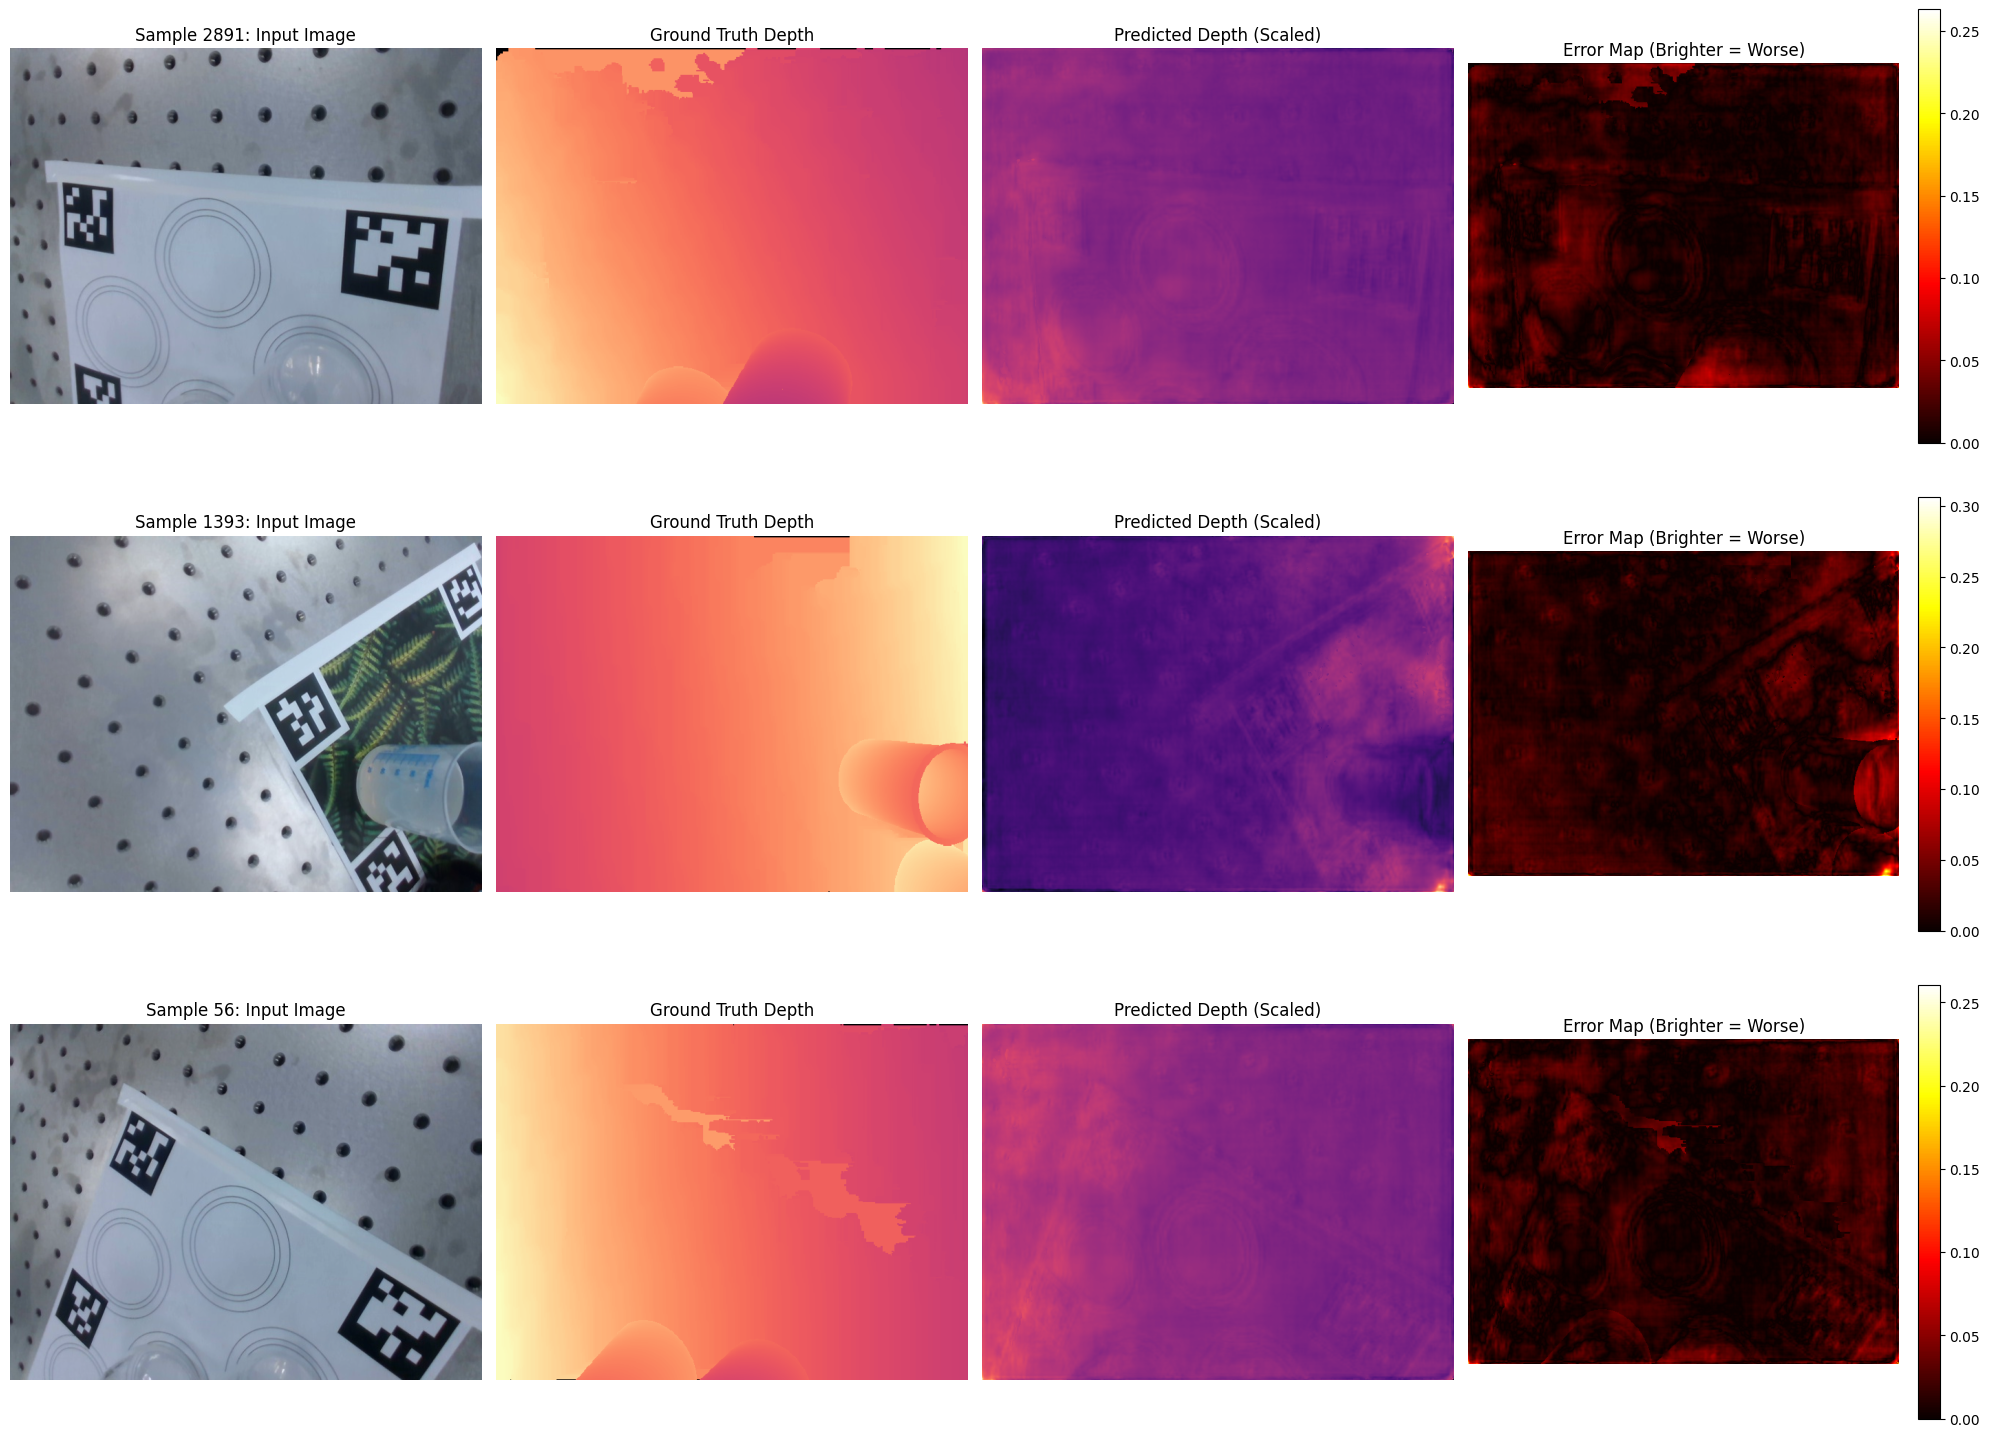

In [8]:
import matplotlib.pyplot as plt
import random
import torch
import numpy as np

def visualize_predictions(model, dataset, num_samples=3):
    model.eval()
    # Pick random indices from the dataset
    indices = random.sample(range(len(dataset)), num_samples)

    fig, axs = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))
    if num_samples == 1: axs = [axs] # Handle single sample edge case

    print(f"Displaying {num_samples} random test samples...")

    with torch.no_grad():
        for i, idx in enumerate(indices):
            # 1. Load Data
            sample = dataset[idx]
            # Add batch dimension: (C, H, W) -> (1, C, H, W)
            pixel_values = sample["pixel_values"].unsqueeze(0).to(device)
            gt_depth = sample["labels"].to(device) # Expected shape (H, W)

            # 2. Inference
            outputs = model(pixel_values=pixel_values)
            pred_depth = outputs.predicted_depth

            # 3. Resize Prediction to match Ground Truth size
            prediction = torch.nn.functional.interpolate(
                pred_depth.unsqueeze(1),
                size=gt_depth.shape[-2:],
                mode="bicubic",
                align_corners=False
            ).squeeze()

            # 4. Median Scaling (Align prediction scale to GT)
            # We only calculate scale based on valid pixels (>0)
            valid_mask = (gt_depth > 0)
            if valid_mask.sum() > 0:
                scale = torch.median(gt_depth[valid_mask]) / torch.median(prediction[valid_mask])
                pred_scaled = prediction * scale
            else:
                pred_scaled = prediction # Fallback (rare)

            # 5. Prepare for Plotting (Move to CPU/Numpy)
            # Normalize Image for display
            img = pixel_values.squeeze(0).permute(1, 2, 0).cpu().numpy()
            img = (img - img.min()) / (img.max() - img.min())

            gt = gt_depth.cpu().numpy()
            pred = pred_scaled.cpu().numpy()

            # Calculate Error Map (Difference)
            error_map = np.abs(gt - pred)
            error_map[~valid_mask.cpu().numpy()] = 0 # Hide error where GT is missing

            # 6. Plot
            # Column 1: Input RGB
            axs[i][0].imshow(img)
            axs[i][0].set_title(f"Sample {idx}: Input Image")
            axs[i][0].axis('off')

            # Column 2: Ground Truth
            axs[i][1].imshow(gt, cmap='magma')
            axs[i][1].set_title("Ground Truth Depth")
            axs[i][1].axis('off')

            # Column 3: Prediction
            axs[i][2].imshow(pred, cmap='magma')
            axs[i][2].set_title("Predicted Depth (Scaled)")
            axs[i][2].axis('off')

            # Column 4: Error Map
            im_err = axs[i][3].imshow(error_map, cmap='hot')
            axs[i][3].set_title("Error Map (Brighter = Worse)")
            axs[i][3].axis('off')

            # Add colorbar to the error map for reference
            plt.colorbar(im_err, ax=axs[i][3], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# Run the function
visualize_predictions(model, dataset, num_samples=3)